# loss_function_demonstration.ipynb
## Author: Connacher Murphy

Demonstrates some of the features of check loss and smooth check loss.

## 0. Load Required Libraries

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import quantile_dnn as qdnn

## 1. Plot the check loss function for various $\tau$ values

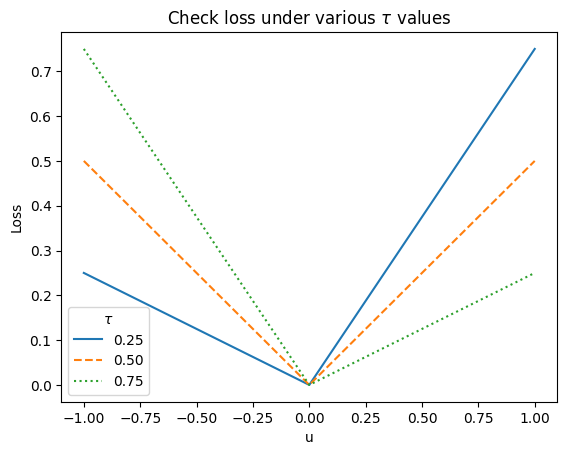

In [50]:
errors = np.arange(-1.0, 1.01, 0.01)
taus = [0.25, 0.5, 0.75]
linestyles = ['-', '--', ':']

for tau, linestyle in zip(taus, linestyles):
    loss = []
    for error in errors:
        loss.append(qdnn.check_loss(torch.tensor(error), torch.tensor(0.0), tau))

    loss = np.array(loss)
    plt.plot(errors, loss, linestyle=linestyle, label="{:.2f}".format(tau))

plt.xlabel("u")
plt.ylabel("Loss")
plt.title("Check loss under various $\\tau$ values")
plt.legend(title="$\\tau$")
plt.show()

## 2. Test the loss functions on unconditional quantiles

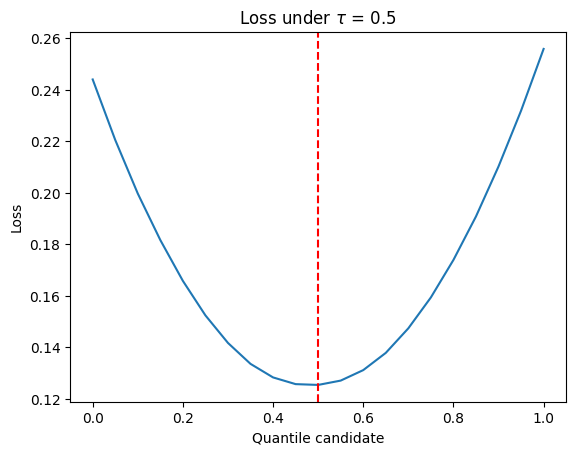

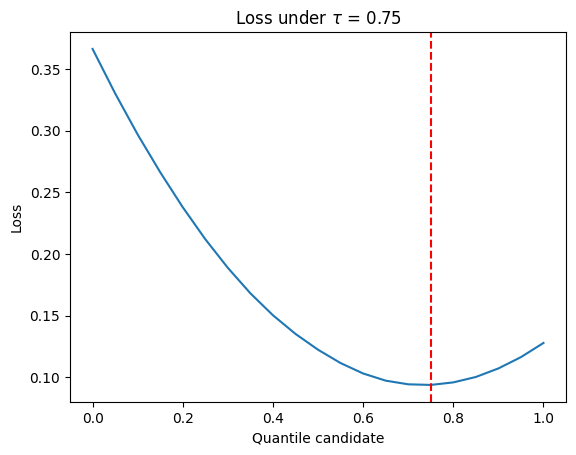

In [51]:
# Set the seed for reproducibility
np.random.seed(123)

# N draws from uniform distribution on [0, 1]
N = 1000
target = torch.rand(N)

# Number of quantile candidates
num_candidates = 20

def sample_loss(N, target, tau, num_candidates):
    """
    Calculate in-sample loss for various candidate quantiles
    Arguments:
        N: number of observations
        target: uniform draws
        tau: quantile
        num_candidates: number of quantile candidates
    """

    # Set of quantiles
    step_size = 1 / num_candidates
    candidates = np.arange(0.0, 1.0 + step_size, step_size)

    # Calculate loss for various quantile candidates
    loss = []
    for candidate in candidates:
        input = candidate * torch.ones(N)
        
        loss.append(qdnn.check_loss(input, target, tau).item())

    loss = np.array(loss)
    plt.plot(candidates, loss)
    plt.axvline(x = tau, color = "red", linestyle = "--")
    plt.xlabel("Quantile candidate")
    plt.ylabel("Loss")
    plt.title(f"Loss under $\\tau$ = {tau}")
    plt.show()

sample_loss(N, target, 0.5, num_candidates)
sample_loss(N, target, 0.75, num_candidates)